<a href="https://colab.research.google.com/github/andreregino/machine-learning-classes/blob/main/Project_3_Pacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3

This assignment aims to apply Evolutionary Algorithms and Reinforcement Learning Methods to solve the Pac-Man
game. We will use as the basic engine the environment available in http://cs.brynmawr.edu/Courses/cs372/fall2017/Code/search.zip. You should download the code and use the smallClassic, mediumClassic, and original-
Classic layouts.

### Running the Code

**ATTENTION** This notebook only explains the problem, the algorithms used to solve the problem, how to run them, the collected results in graph format and a final section with the resume and final considerations. This notebook is not intended to run the algorithm. This action can be done inside the attached folder in this project and by running the following code inside it: 

`!python pacman.py -p RLAgent -x 1000 -n 1010 -l smallClassic`

* -p: the agent (RLAgent is the Reinforcement Learning Agent)

* -x: training iterations

* -n: test iterations

* -l: layout (choose between smallClass, mediumClassic and originalClassic)

# Genetic Algorithm

### Initial parameters

- **Model Adopted**: Genetic Algorithm;
- **Gene**: Python list with 5 floats between 0 and 100; 
- **Chromossome**: 1000 genes in a vector; 
- **Fitness**: Game Score; 
- **Population Size**: 15 individuals; 
- **Initial Population**: Uniform distribution of the genes; 
- **Stop Criteria**: 50 generations;
- **Selection Tecnique**: Tournament with 4 individuals; 
- **Crossover**: Double point with 100 genes change; 
- **Mutation Tecnique**: Swap; 
- **Replacement Method**: Steady State (5 better individuals of last population and (n-5) better of intermediate population) ; 
- **Mutation Rate**: 15%; 
- **Crossover Rate**: 70%; 

In [ ]:
from pacman import GameState,readCommand
from collections import Counter
from game import Agent
from game import Directions
from util import manhattanDistance
import random
import seaborn as sns
import pacman
import random
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

def heuristicDistance(xy1, xy2):
    return xy1[0] - xy2[0] ,  xy1[1] - xy2[1]

def foodDirection(state,weight_closest,weight_all,square):
    east=west=north=south=0 
    best_east=best_west=best_north=best_south=0 
    near_x=near_y=0
    near_food=10000
    for x_ax in range(int(-(square/2)),int((square/2)+1)):
        for y_ax in range(int(-(square/2)),int((square/2)+1)):
            try:
                if state.hasWall(state.getPacmanPosition()[0]+x_ax,state.getPacmanPosition()[1]+y_ax):
                    continue
                else:
                    x = state.getPacmanPosition()[0]+x_ax
                    y = state.getPacmanPosition()[1]+y_ax
                    has_food = state.getFood()[x][y]
                    if has_food:
                        
                        dist=manhattanDistance(state.getPacmanPosition(),[x,y])
                        if dist<near_food:
                            near_food=dist
                            near_x= x
                            near_y= y
                            
                            if abs(x_ax)>abs(y_ax) and x_ax<0:
                                best_west = 0
                                best_west += 1
                            elif abs(x_ax)>abs(y_ax) and x_ax>0:
                                best_east=0
                                best_east += 1
                            elif abs(y_ax)>abs(x_ax) and y_ax<0:
                                best_south=0
                                best_south += 1
                            elif abs(y_ax)>abs(x_ax) and y_ax>0:
                                best_north=0
                                best_north += 1
                            elif abs(y_ax)==abs(x_ax) and y_ax>0 and x_ax>0:
                                best_north=best_east=0
                                best_north += 1
                                best_east += 1
                            elif abs(y_ax)==abs(x_ax) and y_ax>0 and x_ax<0:
                                best_north=best_west=0
                                best_north += 1
                                best_west += 1
                            elif abs(y_ax)==abs(x_ax) and y_ax<0 and x_ax>0:
                                best_south=best_east=0
                                best_south += 1
                                best_east += 1
                            elif abs(y_ax)==abs(x_ax) and y_ax<0 and x_ax<0:
                                best_south=best_west=0
                                best_south += 1
                                best_west += 1
                        
                        if abs(x_ax)>abs(y_ax) and x_ax<0:
                            west += 1
                        elif abs(x_ax)>abs(y_ax) and x_ax>0:
                            east += 1
                        elif abs(y_ax)>abs(x_ax) and y_ax<0:
                            south += 1
                        elif abs(y_ax)>abs(x_ax) and y_ax>0:
                            north += 1
                        elif abs(y_ax)==abs(x_ax) and y_ax>0 and x_ax>0:
                            north += 1
                            east += 1
                        elif abs(y_ax)==abs(x_ax) and y_ax>0 and x_ax<0:
                            north += 1
                            west += 1
                        elif abs(y_ax)==abs(x_ax) and y_ax<0 and x_ax>0:
                            south += 1
                            east += 1
                        elif abs(y_ax)==abs(x_ax) and y_ax<0 and x_ax<0:
                            south += 1
                            west += 1                            
            except:
                continue
                
    actions_count_all={'East':weight_closest*east,'West':weight_closest*west,'North':weight_closest*north,'South':weight_closest*south}
    
    actions_count_near={'East':weight_all*best_east,'West':weight_all*best_west,
                        'North':weight_all*best_north,'South':weight_all*best_south}
    return actions_count_all , actions_count_near

def nextState(state,legal,weight):
    dic = {'East':0,'West':0,'North':0,'South':0}
    score_list = [0,0,0,0]
    for action in dic.keys():
        if action in legal:
            score = state.generatePacmanSuccessor(action).getScore()
            dic[action]=score*weight
    return dic

def nearGhost(state,weight):
    east=west=north=south=0 
    numGhost = state.getNumAgents()
    near_dist = 10000 

    for ghost in range(1,numGhost):
        dist=manhattanDistance(state.getPacmanPosition(),state.getGhostPosition(ghost))
        if dist<near_dist:
            near_dist=dist
            near_ghost=ghost
    
    x,y=heuristicDistance(state.getPacmanPosition(),state.getGhostPosition(near_ghost))

    if abs(x)>abs(y):
        if x>0:
            east += 1
        else:
            west += 1
            
    elif abs(x)==abs(y):
        if x>0:
            east += 1
            north += 1
        else:
            west += 1
            south += 1
    else:
        if y>0:
            north += 1
        else:
            south += 1
                       
    actions_count={'East':weight*east,'West':weight*west,'North':weight*north,'South':weight*south}
    return actions_count
    
def allGhost(state,weight):
    east=west=north=south=0 
    numGhost = state.getNumAgents() 

    for ghost in range(1,numGhost):
        x,y=heuristicDistance(state.getPacmanPosition(),state.getGhostPosition(ghost))
        if abs(x)>abs(y):
            if x>0:
                east += 1
            else:
                west += 1
            
        elif abs(x)==abs(y):
            if x>0:
                east += 1
                north += 1
            else:
                west += 1
                south += 1
        else:
            if y>0:
                north += 1
            else:
                south += 1
           
    actions_count={'East':weight*east,'West':weight*west,'North':weight*north,'South':weight*south}
    return actions_count

class GAAgent(Agent):
    def __init__(self,weights):
        self.weights = weights
        
    def registerInitialState(self, state):
        self.numActions = 0 
        return    
      
    def getAction(self,state):
        self.numActions += 1
        try:
            gene=self.weights.pop(0)
        except:
            return Directions.STOP
        legal = state.getLegalPacmanActions()
        tentativas=0 
        square=2 
        food = state.getNumFood()
        while tentativas<10 and food > 5:
            tentativas+=1 
            square+=2 
            all_food_best_dir, near_food_best_dir = foodDirection(state,int(gene[0]),int(gene[1]),square)
            all_ghost_best_dir = allGhost(state,int(gene[2]))
            near_ghost_best_dir = nearGhost(state,int(gene[3]))
            best_future_action = nextState(state,legal,int(gene[4]))
            final = dict(Counter(all_food_best_dir) + Counter(near_food_best_dir) + 
                     Counter(all_ghost_best_dir)+
                     Counter(near_ghost_best_dir)+
                     Counter(best_future_action))
            final = dict(sorted(final.items(), key=lambda item: item[1],reverse=True))
            for i in range(len(final)):
                best_dir = list(final.keys())[i]
                if best_dir in legal:
                    return best_dir
        
        all_food_best_dir, near_food_best_dir = foodDirection(state,int(gene[0]),int(gene[1]),square)
        best_future_action = nextState(state,legal,int(gene[4]))
        final = dict(Counter(near_food_best_dir) + Counter(best_future_action))
        final = dict(sorted(final.items(), key=lambda item: item[1],reverse=True))
        for i in range(len(final)):
            best_dir = list(final.keys())[i]
            if best_dir in legal:
                return best_dir
        final = dict(sorted(near_food_best_dir.items(), key=lambda item: item[1],reverse=True))
        if list(final.keys())[0] in legal:
            return list(final.keys())[0]
        return random.choice(legal)

In [ ]:
class GeneticAlg():

    def __init__(self, popSize, mutationRate, crossoverRate, tournmentSize, numTentativas, generations, world):
        self.popSize = popSize
        self.mutationRate = mutationRate
        self.crossoverRate = crossoverRate
        self.tournmentSize = tournmentSize
        self.numTentativas = numTentativas
        self.generations = generations
        self.world = world

    def generateGene(self):
        gene=[]
        for weight in range(0,5):
            gene.append(random.uniform(0, 100))
        return gene

    def generateindividual(self):
        individual=[]
        for jogadas in range(0,1000):
            individual.append(self.generateGene())
        return individual

    def generatePopulation(self):
        population=[]
        for i in range(0,self.popSize):
            individual = self.generateindividual()
            individual_temp=individual 
            population.append(individual)
        return population

    def pacmanAvarageScore(self, individual, flag=True):
        tentativas_ind=[]
        actions_list = []
        layouts=[self.world]
        for layout in layouts:
            for tentativas in range(0,self.numTentativas):
                if flag:
                    args = ['--layout',layout,'--pacman','DumbAgent','-q']
                else:
                    args = ['--layout',layout,'--pacman','DumbAgent']
                args_list = readCommand(args)
                test = GAAgent(individual)
                score= pacman.runGames(pacman=test,layout=args_list['layout'],ghosts=args_list['ghosts'],display=args_list['display'],
                            numGames=args_list['numGames'],record=args_list['record'])
                tentativas_ind.append(score[0].state.getScore())
                actions_list.append(test.numActions)
        return np.mean(tentativas_ind), np.mean(actions_list)

    def evaluatePopulation(self, population):
        scores_pop =[]
        actions_pop = []
        for i in range(0,len(population)):
            individual = population[i]
            individual_temp=deepcopy(individual)
            avg_score, avg_actions = self.pacmanAvarageScore(individual_temp)
            scores_pop.append(avg_score)
            actions_pop.append(avg_actions)
        return scores_pop, actions_pop

    def mutation(self, population):
        for selected in range(int(len(population)*self.mutationRate)):
            position_individual = random.randint(0,len(population)-1)
            position_cromossom1 = random.randint(0,len(population[position_individual])-1)
            position_cromossom2 = random.randint(0,len(population[position_individual])-1)
            crom1 = population[position_individual][position_cromossom1]
            crom2 = population[position_individual][position_cromossom2]
            
            population[position_individual][position_cromossom1] = crom2
            population[position_individual][position_cromossom2] = crom1
        return population

    def tournament(self, pairs):
        tournament_pop=[]
        for number in range(self.tournmentSize):
            position_individual = random.randint(0,len(pairs)-1)
            individual = pairs[position_individual]
            tournament_pop.append(individual)
        tournament_pop.sort(reverse=True, key=lambda li: li[0])
        return tournament_pop[0]

    def crossover(self, pairs, range_cromossomos, rand):
        novos_pares=[]
        for i in range(int((len(pairs)*self.crossoverRate)/2)):
            
            individual1 = self.tournament(pairs)
            individual2 = self.tournament(pairs)
     
            crom1_list = individual1[1][rand:rand+range_cromossomos]
            crom2_list = individual2[1][rand:rand+range_cromossomos]
                
            individual1[1][rand:rand+range_cromossomos] = crom2_list
            individual2[1][rand:rand+range_cromossomos] = crom1_list
            novos_pares.append(individual1)
            novos_pares.append(individual2)
        population = [el[1] for el in novos_pares]
        return population

    def makePairs(self, scores, population):
        lista=[]
        for i in range(len(population)):
            item=[scores[i], population[i]]
            lista.append(item)
        lista.sort(reverse=True, key=lambda li: li[0])
        return lista

    def mergePopulationAndScores(self, pairs,pairs_linha):
        pop = pairs[:5] + pairs_linha[:-5]
        population = [el[1] for el in pop]
        scores = [el[0] for el in pop]
        return population, scores

    def evalBetterIndividual(self):
        args = ['--layout',self.world,'--pacman','DumbAgent', '-n', '10', '-q']
        args_list = readCommand(args)
        test = GAAgent(self.best_individual)
        score= pacman.runGames(pacman=test,layout=args_list['layout'],ghosts=args_list['ghosts'],display=args_list['display'],
                    numGames=args_list['numGames'],record=args_list['record'])
        
    def final(self):
        self.scores = {}
        self.actions = {}
        
        P = self.generatePopulation()
        scores_aux, actions_aux = self.evaluatePopulation(P)
        
        self.scores[0] = scores_aux
        self.actions[0] = actions_aux
        self.best_individual = P[np.array(self.scores[0]).argmax()]
        
        t = 1
        while t <= 50: 
            pairs = self.makePairs(scores_aux,P)
            pairs_duplication = pairs[:int(len(pairs)*0.2)]
            Pduplication = [el[1] for el in pairs_duplication]
            rand = np.random.randint(0,600)
            Pcrossover = self.crossover(pairs,100,rand)
            
            Plinha = Pcrossover + Pduplication
            
            Plinha = self.mutation(Plinha)

            scores_linha, actions_linha = self.evaluatePopulation(Plinha)
            pairs_linha = self.makePairs(scores_linha,Plinha)
            
            P, scores_aux = self.mergePopulationAndScores(pairs,pairs_linha)
            self.scores[t] = scores_aux
            self.actions[t] = actions_linha
            
            self.best_individual = P[np.array(self.scores[t]).argmax()]
            print('\n\n -----> GENERATION ',t)
            print('Best Individual Score: ', np.array(scores_aux).max())
            print('Average Score: ', np.array(scores_aux).mean())
            print('\n\n')
            t += 1
        self.evalBetterIndividual()

## Small Classic

In [ ]:
sm_ga = GeneticAlg(15, 0.15, 0.7, 4, 3, 50, 'smallClassic')
sm_ga.final()

Pacman died! Score: -272
Average Score: -272.0
Scores:        -272.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -198
Average Score: -198.0
Scores:        -198.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -201
Average Score: -201.0
Scores:        -201.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -269
Average Score: -269.0
Scores:        -269.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -146
Average Score: -146.0
Scores:        -146.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -69
Average Score: -69.0
Scores:        -69.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -108
Average Score: -108.0
Scores:        -108.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -314
Average Score: -314.0
Scores:        -314.0
Win Rate:     

Pacman died! Score: -487
Average Score: -487.0
Scores:        -487.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -191
Average Score: -191.0
Scores:        -191.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -303
Average Score: -303.0
Scores:        -303.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -205
Average Score: -205.0
Scores:        -205.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -231
Average Score: -231.0
Scores:        -231.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -117
Average Score: -117.0
Scores:        -117.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -327
Average Score: -327.0
Scores:        -327.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -240
Average Score: -240.0
Scores:        -240.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 69
Average Score: 69.0
Scores:        69.0
Win Rate:      0/

Pacman died! Score: 332
Average Score: 332.0
Scores:        332.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -186
Average Score: -186.0
Scores:        -186.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -66
Average Score: -66.0
Scores:        -66.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -156
Average Score: -156.0
Scores:        -156.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -144
Average Score: -144.0
Scores:        -144.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -78
Average Score: -78.0
Scores:        -78.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -288
Average Score: -288.0
Scores:        -288.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -73
Average Score: -73.0
Scores:        -73.0
Win Rate:      0/1 (0.0

Pacman died! Score: -359
Average Score: -359.0
Scores:        -359.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -194
Average Score: -194.0
Scores:        -194.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -184
Average Score: -184.0
Scores:        -184.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman emerges victorious! Score: 675
Average Score: 675.0
Scores:        675.0
Win Rate:      1/1 (1.00)
Record:        Win
Pacman died! Score: -173
Average Score: -173.0
Scores:        -173.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  11
Best Individual Score:  241.0
Average Score:  147.93333333333334



Pacman died! Score: -142
Average Score: -142.0
Scores:        -142.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -335
Average Score: -335.0
Scores:        -335.0
Win Rate:      0/1 (0.0

Pacman died! Score: -363
Average Score: -363.0
Scores:        -363.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -345
Average Score: -345.0
Scores:        -345.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  18
Best Individual Score:  241.0
Average Score:  147.93333333333334



Pacman died! Score: -3
Average Score: -3.0
Scores:        -3.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -267
Average Score: -267.0
Scores:        -267.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 136
Average Score: 136.0
Scores:        136.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -337
Average Score: -337.0
Scores:        -337.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -267
Average Score: -267.0
Scores:        -267.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -144
Average Score: -144.0
Scores:        -144.0
Win Rate:      0/1 (0.00)
Record:        L

Pacman died! Score: -373
Average Score: -373.0
Scores:        -373.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -305
Average Score: -305.0
Scores:        -305.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman emerges victorious! Score: 1552
Average Score: 1552.0
Scores:        1552.0
Win Rate:      1/1 (1.00)
Record:        Win
Pacman died! Score: -158
Average Score: -158.0
Scores:        -158.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -280
Average Score: -280.0
Scores:        -280.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -375
Average Score: -375.0
Scores:        -375.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -125
Average Score: -125.0
Scores:        -125.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  26
Best Individual Score:  241.0
Average Score:  147.93333333333334



Pacman died! Score: -191
Average Score: -191.0
Scores:        -191.0
Win Rate:      0/1 (

Pacman died! Score: -225
Average Score: -225.0
Scores:        -225.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -44
Average Score: -44.0
Scores:        -44.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  33
Best Individual Score:  241.0
Average Score:  147.93333333333334



Pacman died! Score: -230
Average Score: -230.0
Scores:        -230.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman emerges victorious! Score: 915
Average Score: 915.0
Scores:        915.0
Win Rate:      1/1 (1.00)
Record:        Win
Pacman died! Score: -102
Average Score: -102.0
Scores:        -102.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -161
Average Score: -161.0
Scores:        -161.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)


Pacman died! Score: -129
Average Score: -129.0
Scores:        -129.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman emerges victorious! Score: 979
Average Score: 979.0
Scores:        979.0
Win Rate:      1/1 (1.00)
Record:        Win
Pacman died! Score: -87
Average Score: -87.0
Scores:        -87.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -279
Average Score: -279.0
Scores:        -279.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -203
Average Score: -203.0
Scores:        -203.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -234
Average Score: -234.0
Scores:        -234.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -20
Average Score: -20.0
Scores:        -20.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -118
Average Score: -118.0
Scores:        -118.0
Win Rat

Pacman died! Score: -395
Average Score: -395.0
Scores:        -395.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -108
Average Score: -108.0
Scores:        -108.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -238
Average Score: -238.0
Scores:        -238.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -201
Average Score: -201.0
Scores:        -201.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  48
Best Individual Score:  241.0
Average Score:  147.93333333333334



Pacman died! Score: -80
Average Score: -80.0
Scores:        -80.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -180
Average Score: -180.0
Scores:        -180.0
Win Rate:      0/1 (0.00)
Record:   

As we can see above, our algorithm did not converge to an optimal solution in small classic layout. The output also shows that it it did not win the game in many training occasions and, in the tests cases, it lost in all the 10 episodes.

In [ ]:
scores_sm = list(sm_ga.scores.values())
better_sm = [np.max(x) for x in scores_sm]
worst_sm = [np.min(x) for x in scores_sm]
average_sm = [np.mean(x) for x in scores_sm]

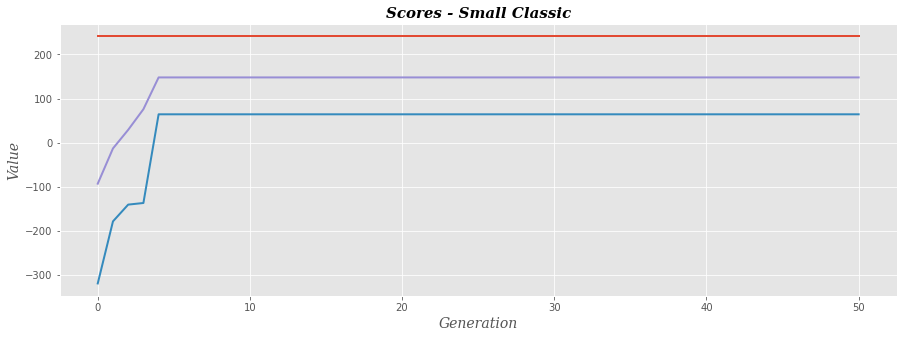

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(better_sm))], better_sm, linewidth=2)
ax1.plot([i for i in range(len(worst_sm))], worst_sm, linewidth=2)
ax1.plot([i for i in range(len(average_sm))], average_sm, linewidth=2)

ax1.set_title('Scores - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

We derived the above plot to verify what could have happened. The plot is composed by 3 "lines", indicating the best scores (in red), the average (in purple) and the worst (in green). This points out that the algorithm stoped in a local minimum, when all the bests scores in the generations with a value of 261. 

We also noted a growth in the initial generations (generation < 5) on the average and worst scores. However, this growth stops and before the 10th generation the algorithm did not show any significative difference in the values.

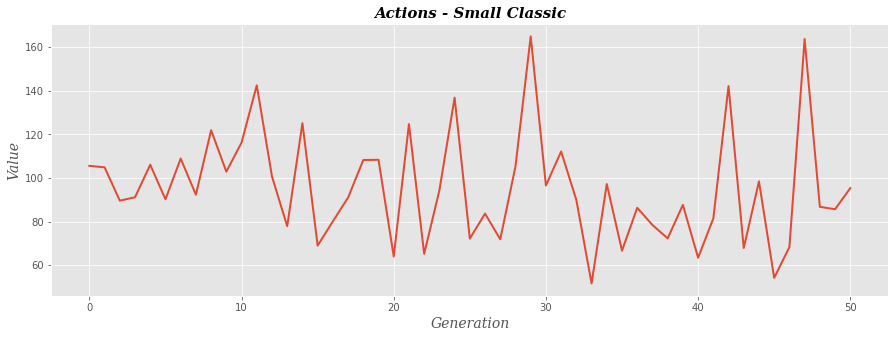

In [ ]:
actions_sm = list(sm_ga.actions.values())
average_sm = [np.mean(x) for x in actions_sm]

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(average_sm))], average_sm, linewidth=2)

ax1.set_title('Actions - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

Above we plot the number of actions done by pacman in each of the 50 generations. We can only see actions higher than 160 with high number of generations (29 and 47). We could not clearly see any other pattern within the obtained results in small classic layout.

## Medium Classic

In [ ]:
mc_ga = GeneticAlg(15, 0.15, 0.7, 4, 3, 50, 'mediumClassic')
mc_ga.final()

Pacman died! Score: 510
Average Score: 510.0
Scores:        510.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 604
Average Score: 604.0
Scores:        604.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 377
Average Score: 377.0
Scores:        377.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 362
Average Score: 362.0
Scores:        362.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 213
Average Score: 213.0
Scores:        213.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 67
Average Score: 67.0
Scores:        67.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 189
Average Score: 189.0
Scores:        189.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 302
Average Score: 302.0
Scores:        302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -246
Average Score: -246.0
Scores:        -246.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 178
Average Score: 178.0
Scores:        178.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 264
Average Score: 264.0
Scores:        264.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 199
Average Score: 199.0
Scores:        199.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -170
Average Score: -170.0
Scores:        -170.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -105
Average Score: -105.0
Scores:        -105.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 14
Average Score: 14.0
Scores:        14.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 487
Average Score: 487.0
Scores:        487.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 37
Average Score: 37.0
Scores:        37.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 139
Average Score: 139.0
Scores:        139.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 242
Average Score: 242.0
Scores:        242.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 62
Average Score: 62.0
Scores:        62.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 193
Average Score: 193.0
Scores:        193.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -304
Average Score: -304.0
Scores:        -304.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 575
Average Score: 575.0
Scores:        575.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -203
Average Score: -203.0
Scores:        -203.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -357
Average Score: -357.0
Scores:        -357.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -576
Average Score: -576.0
Scores:        -576.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -549
Average Score: -549.0
Scores:        -549.0
Win Rate:      0/1 (0.00)


Pacman died! Score: 117
Average Score: 117.0
Scores:        117.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 125
Average Score: 125.0
Scores:        125.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 826
Average Score: 826.0
Scores:        826.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 130
Average Score: 130.0
Scores:        130.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1000
Average Score: 1000.0
Scores:        1000.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  11
Best Individual Score:  630.0
Average Score:  510.6666666666667



Pacman died! Score: 381
Average Score: 381.0
Scores:        381.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 272
Average Score: 272.0
Scores:        272.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -286
Average Score: -286.0
Scores:        -286.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman

Pacman died! Score: 130
Average Score: 130.0
Scores:        130.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 422
Average Score: 422.0
Scores:        422.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  18
Best Individual Score:  630.0
Average Score:  510.6666666666667



Pacman died! Score: 95
Average Score: 95.0
Scores:        95.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 244
Average Score: 244.0
Scores:        244.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -198
Average Score: -198.0
Scores:        -198.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 373
Average Score: 373.0
Scores:        373.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 384
Average Score: 384.0
Scores:        384.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman di

Pacman died! Score: -190
Average Score: -190.0
Scores:        -190.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 632
Average Score: 632.0
Scores:        632.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 255
Average Score: 255.0
Scores:        255.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -216
Average Score: -216.0
Scores:        -216.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman emerges victorious! Score: 1651
Average Score: 1651.0
Scores:        1651.0
Win Rate:      1/1 (1.00)
Record:        Win
Pacman died! Score: -217
Average Score: -217.0
Scores:        -217.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -32
Average Score: -32.0
Scores:        -32.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 293
Average Score: 293.0
Scores:        293.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  26
Best Individual Score:  630.0
Average Score:  510.6666

Pacman died! Score: 8
Average Score: 8.0
Scores:        8.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 29
Average Score: 29.0
Scores:        29.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 110
Average Score: 110.0
Scores:        110.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 526
Average Score: 526.0
Scores:        526.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  33
Best Individual Score:  630.0
Average Score:  510.6666666666667



Pacman died! Score: -533
Average Score: -533.0
Scores:        -533.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 343
Average Score: 343.0
Scores:        343.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -172
Average Score: -172.0
Scores:        -172.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 312
Average Score: 312.0
Scores:        312.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Sc

Pacman died! Score: 451
Average Score: 451.0
Scores:        451.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -313
Average Score: -313.0
Scores:        -313.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -220
Average Score: -220.0
Scores:        -220.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 76
Average Score: 76.0
Scores:        76.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 151
Average Score: 151.0
Scores:        151.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 646
Average Score: 646.0
Scores:        646.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -293
Average Score: -293.0
Scores:        -293.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 238
Average Score: 238.0
Scores:        238.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 320
Average Score: 320.0
Scores:        320.0
Win Rate:      0/1 (0.00)
Record

Pacman died! Score: 88
Average Score: 88.0
Scores:        88.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 300
Average Score: 300.0
Scores:        300.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -3
Average Score: -3.0
Scores:        -3.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 319
Average Score: 319.0
Scores:        319.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -257
Average Score: -257.0
Scores:        -257.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  48
Best Individual Score:  630.0
Average Score:  510.6666666666667



Pacman died! Score: 13
Average Score: 13.0
Scores:        13.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 185
Average Score: 185.0
Scores:        185.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 171
Average Score: 171.0
Scores:        171.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score

As we can see above, our algorithm did not converge to an optimal solution in medium classic layout. The output also shows that it it did not win the game in many training occasions and, in the tests cases, it lost in all the 10 episodes with an average score of -117, lesser than the one found in small classic.

In [ ]:
scores_mc = list(mc_ga.scores.values())
better_mc = [np.max(x) for x in scores_mc]
worst_mc = [np.min(x) for x in scores_mc]
average_mc = [np.mean(x) for x in scores_mc]

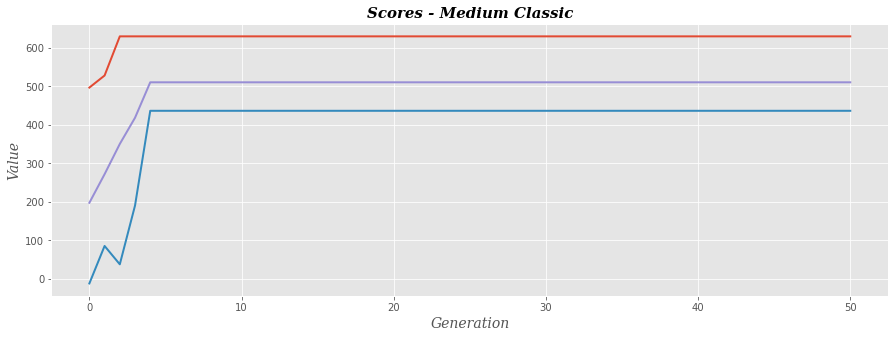

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(better_mc))], better_mc, linewidth=2)
ax1.plot([i for i in range(len(worst_mc))], worst_mc, linewidth=2)
ax1.plot([i for i in range(len(average_mc))], average_mc, linewidth=2)

ax1.set_title('Scores - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

We derived the above plot to verify what could have happened. The plot is composed by 3 "lines", indicating the best scores (in red), the average (in purple) and the worst (in green). This points out that the algorithm stoped in a local minimum, when all the bests scores in the generations with a value of 650, higher than the 261 in small classic layout. 

We also noted a growth in the initial generations (generation < 5) on the average and worst scores. However, this growth stops and before the 10th generation the algorithm did not show any significative difference in the values.

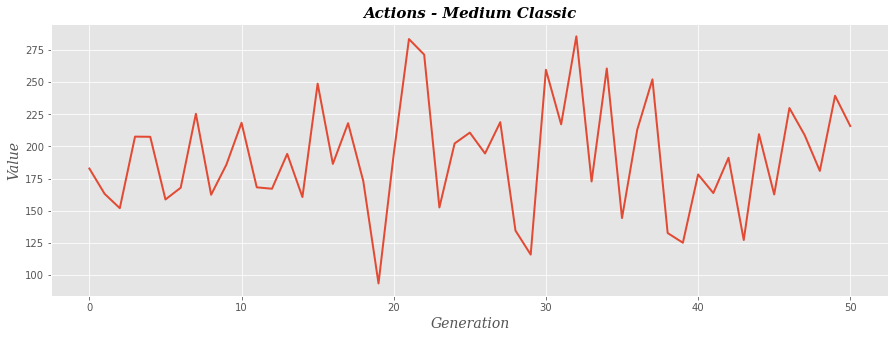

In [ ]:
actions_mc = list(mc_ga.actions.values())
average_mc = [np.mean(x) for x in actions_mc]

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(average_mc))], average_mc, linewidth=2)

ax1.set_title('Actions - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

Above we plot the number of actions done by pacman in each of the 50 generations. The number of actions varied from 100 to 280, a higher number in comparison to the small classic layout.

## Original Classic

In [ ]:
oc_ga = GeneticAlg(15, 0.15, 0.7, 4, 3, 50, 'originalClassic')
oc_ga.final()

Pacman died! Score: 1014
Average Score: 1014.0
Scores:        1014.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -294
Average Score: -294.0
Scores:        -294.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 370
Average Score: 370.0
Scores:        370.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -50
Average Score: -50.0
Scores:        -50.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -74
Average Score: -74.0
Scores:        -74.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -312
Average Score: -312.0
Scores:        -312.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 598
Average Score: 598.0
Scores:        598.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 210
Average Score: 210.0
Scores:        210.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 860
Average Score: 860.0
Scores:        860.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: 34
Average Score: 34.0
Scores:        34.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -350
Average Score: -350.0
Scores:        -350.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -77
Average Score: -77.0
Scores:        -77.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -378
Average Score: -378.0
Scores:        -378.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -461
Average Score: -461.0
Scores:        -461.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 264
Average Score: 264.0
Scores:        264.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 168
Average Score: 168.0
Scores:        168.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -243
Average Score: -243.0
Scores:        -243.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 721
Average Score: 721.0
Scores:        721.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: -624
Average Score: -624.0
Scores:        -624.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 214
Average Score: 214.0
Scores:        214.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -150
Average Score: -150.0
Scores:        -150.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 28
Average Score: 28.0
Scores:        28.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 681
Average Score: 681.0
Scores:        681.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -85
Average Score: -85.0
Scores:        -85.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -84
Average Score: -84.0
Scores:        -84.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 154
Average Score: 154.0
Scores:        154.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 59
Average Score: 59.0
Scores:        59.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: -139
Average Score: -139.0
Scores:        -139.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 814
Average Score: 814.0
Scores:        814.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 322
Average Score: 322.0
Scores:        322.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -40
Average Score: -40.0
Scores:        -40.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -598
Average Score: -598.0
Scores:        -598.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -650
Average Score: -650.0
Scores:        -650.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  11
Best Individual Score:  556.0
Average Score:  403.06666666666666



Pacman died! Score: 1213
Average Score: 1213.0
Scores:        1213.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -247
Average Score: -247.0
Scores:        -247.0
Win Rate:      0/1 (0.00)
Record:        L

Pacman died! Score: 34
Average Score: 34.0
Scores:        34.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 267
Average Score: 267.0
Scores:        267.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  18
Best Individual Score:  556.0
Average Score:  403.06666666666666



Pacman died! Score: 22
Average Score: 22.0
Scores:        22.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 407
Average Score: 407.0
Scores:        407.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -414
Average Score: -414.0
Scores:        -414.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 276
Average Score: 276.0
Scores:        276.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -288
Average Score: -288.0
Scores:        -288.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 243
Average Score: 243.0
Scores:        243.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died

Pacman died! Score: -232
Average Score: -232.0
Scores:        -232.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 964
Average Score: 964.0
Scores:        964.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -346
Average Score: -346.0
Scores:        -346.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 156
Average Score: 156.0
Scores:        156.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 237
Average Score: 237.0
Scores:        237.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -220
Average Score: -220.0
Scores:        -220.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 52
Average Score: 52.0
Scores:        52.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -100
Average Score: -100.0
Scores:        -100.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  26
Best Individual Score:  556.0
Average Score:  403.06666666666666



Pa

Pacman died! Score: 95
Average Score: 95.0
Scores:        95.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 148
Average Score: 148.0
Scores:        148.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 51
Average Score: 51.0
Scores:        51.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -128
Average Score: -128.0
Scores:        -128.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  33
Best Individual Score:  556.0
Average Score:  403.06666666666666



Pacman died! Score: -75
Average Score: -75.0
Scores:        -75.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -238
Average Score: -238.0
Scores:        -238.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -274
Average Score: -274.0
Scores:        -274.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -79
Average Score: -79.0
Scores:        -79.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman d

Pacman died! Score: -152
Average Score: -152.0
Scores:        -152.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 720
Average Score: 720.0
Scores:        720.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -474
Average Score: -474.0
Scores:        -474.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 995
Average Score: 995.0
Scores:        995.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -16
Average Score: -16.0
Scores:        -16.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 25
Average Score: 25.0
Scores:        25.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -348
Average Score: -348.0
Scores:        -348.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 189
Average Score: 189.0
Scores:        189.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: 119
Average Score: 119.0
Scores:        119.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 31
Average Score: 31.0
Scores:        31.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 728
Average Score: 728.0
Scores:        728.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -236
Average Score: -236.0
Scores:        -236.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 450
Average Score: 450.0
Scores:        450.0
Win Rate:      0/1 (0.00)
Record:        Loss


 -----> GENERATION  48
Best Individual Score:  556.0
Average Score:  403.06666666666666



Pacman died! Score: 401
Average Score: 401.0
Scores:        401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -8
Average Score: -8.0
Scores:        -8.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died

As we can see above, our algorithm did not converge to an optimal solution in medium classic layout. The output also shows that it it did not win the game in many training occasions and, in the tests cases, it lost in all the 10 episodes with an average score of -1493, lesser than the one found in small classic and medium classic layout.

In [ ]:
scores_oc = list(oc_ga.scores.values())
better_oc = [np.max(x) for x in scores_oc]
worst_oc = [np.min(x) for x in scores_oc]
average_oc = [np.mean(x) for x in scores_oc]

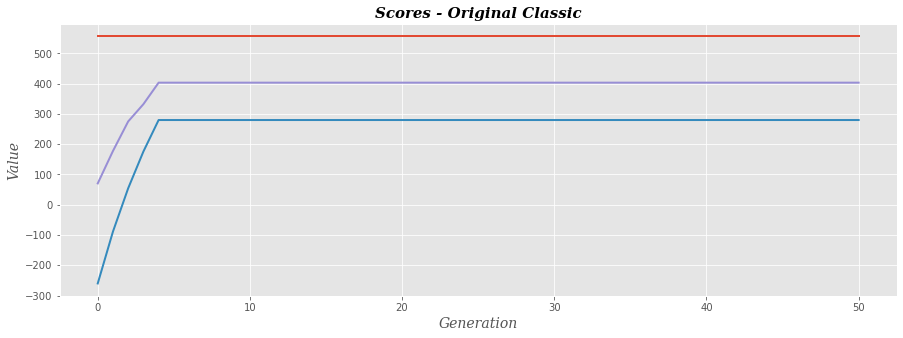

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(better_oc))], better_oc, linewidth=2)
ax1.plot([i for i in range(len(worst_oc))], worst_oc, linewidth=2)
ax1.plot([i for i in range(len(average_oc))], average_oc, linewidth=2)

ax1.set_title('Scores - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

We derived the above plot to verify what could have happened. The plot is composed by 3 "lines", indicating the best scores (in red), the average (in purple) and the worst (in green). This points out that the algorithm stoped in a local minimum, when all the bests scores in the generations with a value close to the medium classic layout, higher than the 261 in small classic layout. 

We also noted a growth in the initial generations (generation < 5) on the average and worst scores. However, this growth stops and before the 10th generation the algorithm did not show any significative difference in the values. 

The values are worse when we compare to the medium classic values because the best individual in this layout scored less than the better individual in the medium classic, even though the original classic has more available food than medium classic.

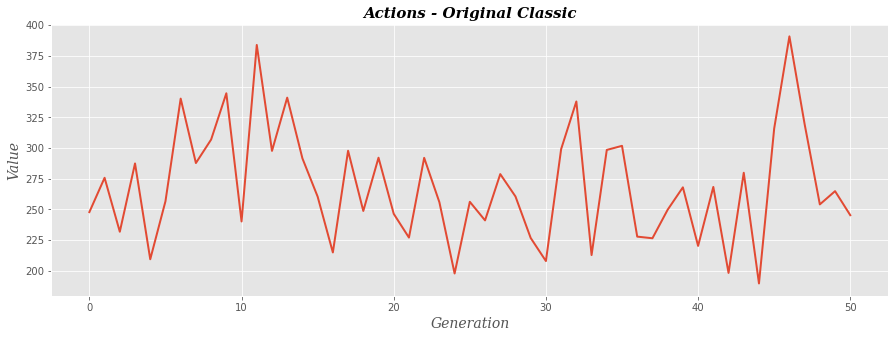

In [ ]:
actions_oc = list(oc_ga.actions.values())
average_oc = [np.mean(x) for x in actions_oc]

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot([i for i in range(len(average_oc))], average_oc, linewidth=2)

ax1.set_title('Actions - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Generation', fontdict=axis_font)
plt.show()

Above we plot the number of actions done by pacman in each of the 50 generations. The number of actions varied from 180 to 380, a higher number in comparison to the small and medium classic layout.

# Reinforcement Learning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


title_font = {'family': 'serif',
        'weight': 'bold',
        'size': 15,
        'style':'italic'}

axis_font = {'family': 'serif',
        'size': 14,
        'style':'italic'}
plt.style.use('ggplot')

In our experiments we use the random ghosts and Aproximate Q-Learning to model the game. We use 4 features to represent a state: number of ghost 1 step and 2 steps away, closest food and if there is no ghost one step away and a food available.

In [ ]:
from game import *

import random,util,math,time
import util
import pandas as pd 

def closestFood(pos, food, walls):
    matrix = [(pos[0], pos[1], 0)]
    neigh = set()
    while matrix:

        pos_x, pos_y, dist = matrix.pop(0)
        if (pos_x, pos_y) not in neigh:
            neigh.add((pos_x, pos_y))

            if food[pos_x][pos_y]:
                return dist

            nbrs = Actions.getLegalNeighbors((pos_x, pos_y), walls)
            for nbr_x, nbr_y in nbrs:
                matrix.append((nbr_x, nbr_y, dist+1))
    return None

class RLAgent():

    def __init__(self, alpha=1.0, epsilon=0.05, gamma=0.8, numTraining = 10):
        self.episodesSoFar = 0
        self.accumTrainRewards = 0.0
        self.accumTestRewards = 0.0
        self.numTraining = int(numTraining)
        self.epsilon = float(epsilon)
        self.alpha = float(alpha)
        self.discount = float(gamma)
        self.QValues = util.Counter()
        self.weights = util.Counter() 
        self.scores = []
        self.actions = []
        self.importance = []
        self.rewards = []

    def stopEpisode(self):
        if self.episodesSoFar < self.numTraining:
            self.accumTrainRewards += self.episodeRewards
        else:
            self.accumTestRewards += self.episodeRewards
        self.episodesSoFar += 1
        if self.episodesSoFar >= self.numTraining:
            self.epsilon = 0.0    
            self.alpha = 0.0     

    def computeValueFromQValues(self, state):
        values = [self.getQValue(state, action) for action in state.getLegalActions()]
        if (values):
            return max(values)
        else:
            return 0.0 

    def computeActionFromQValues(self, state):
        legal_actions = state.getLegalActions()

        value = self.computeValueFromQValues(state)
        for action in legal_actions:
            if (value == self.getQValue(state, action)):
                return action

    def getAction(self, state):
        legalActions = state.getLegalActions()
        action = None

        if (util.flipCoin(self.epsilon)):
            action = random.choice(legalActions)
        else:
            action = self.computeActionFromQValues(state)

        self.lastState = state
        self.lastAction = action
        self.numActions += 1

        return action

    def getFeatures(self, state, action):
        food = state.getFood()
        walls = state.getWalls()
        ghosts = state.getGhostPositions()
        capsule = state.getCapsules()

        features = util.Counter()

        x, y = state.getPacmanPosition()
        dx, dy = Actions.directionToVector(action)
        next_x, next_y = int(x + dx), int(y + dy)
        next_2x, next_2y = int(x + 2*dx), int(y + 2*dy)

        features["#-of-ghosts-1-step-away"] = sum((next_x, next_y) in Actions.getLegalNeighbors(g, walls) for g in ghosts)
        features["#-of-ghosts-2-step-away"] = sum((next_2x, next_2y) in Actions.getLegalNeighbors(g, walls) for g in ghosts)

        if not features["#-of-ghosts-1-step-away"] and food[next_x][next_y]:
            features["eats-food"] = 1.0

        dist = closestFood((next_x, next_y), food, walls)
        if dist is not None:
            features["closest-food"] = float(dist) / (walls.width * walls.height)

        features.divideAll(10.0)
        return features

    def getQValue(self, state, action):
        features = self.getFeatures(state,action)
        QValue = 0.0

        for feature in features:
            QValue += self.weights[feature] * features[feature]

        return QValue

    def update(self, state, action, nextState, reward):
        QValue = 0
        difference = reward + (self.discount * self.computeValueFromQValues(nextState) - self.getQValue(state, action))
        features = self.getFeatures(state, action)

        for feature in features:
            self.weights[feature] += self.alpha * features[feature] * difference

    def registerInitialState(self, state):
        self.lastState = None
        self.lastAction = None
        self.episodeRewards = 0.0
        self.numActions = 0

        if self.episodesSoFar == 0:
            print('Beginning %d episodes of Training' % (self.numTraining))

    def final(self, state):
        deltaReward = state.getScore() - self.lastState.getScore()
        self.episodeRewards += deltaReward   
        self.update(self.lastState, self.lastAction, state, deltaReward)
        self.stopEpisode()

        if not 'lastWindowAccumRewards' in self.__dict__:
            self.lastWindowAccumRewards = 0.0
        self.lastWindowAccumRewards += state.getScore()

        NUM_EPS_UPDATE = 5
        if self.episodesSoFar % NUM_EPS_UPDATE == 0: 
            trainAvg = self.accumTrainRewards / float(self.episodesSoFar)
            self.lastWindowAccumRewards = 0.0
            self.rewards.append(trainAvg)
            
        self.scores.append(state.getScore())
        self.actions.append(self.numActions)
        self.importance.append(self.weights)

        if self.episodesSoFar == self.numTraining:
            msg = 'Training Process is Done'
            print ('%s\n%s' % (msg,'-' * len(msg)))
            print ('\tAverage Rewards over all training: %.2f' % (
                    trainAvg))

            data = pd.DataFrame()
            data['Scores'] = self.scores 
            data['Actions'] = self.actions
            data['Weights'] = self.importance
            data['rewards'] = self.rewards
            
            data.to_excel('data_pacman.xlsx')

## Small Classic World

In [ ]:
!python pacman.py -p RLAgent -x 1000 -n 1010 -l smallClassic -q

Beginning 1000 episodes of Training
Training Process is Done
------------------------
	1000 training episodes 
	Average Rewards over all training: 144.98
Pacman emerges victorious! Score: 975
Pacman emerges victorious! Score: 979
Pacman died! Score: -76
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 973
Pacman emerges victorious! Score: 983
Pacman emerges victorious! Score: 971
Pacman emerges victorious! Score: 983
Pacman emerges victorious! Score: 977
Pacman emerges victorious! Score: 987
Average Score: 873.4
Scores:        975.0, 979.0, -76.0, 982.0, 973.0, 983.0, 971.0, 983.0, 977.0, 987.0
Win Rate:      9/10 (0.90)
Record:        Win, Win, Loss, Win, Win, Win, Win, Win, Win, Win


As we see in the results bellow, the model get 90% in the tests cases on small classic world, with 1000 training episodes. The average score in the tests episodes is 863 points.

In [ ]:
small_data = pd.read_excel('data_pacman.xlsx')
small_rewards = pd.read_excel('rewards_pacman.xlsx')

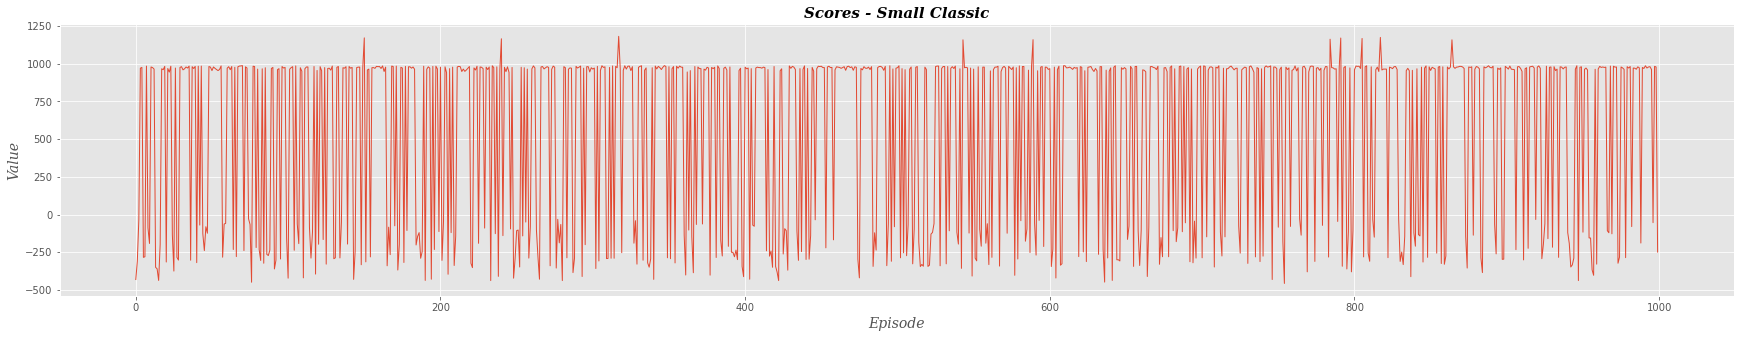

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(small_data))], small_data.Scores, linewidth=1)
ax1.set_title('Scores - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

The score on the training episodes does not have a tendency and changes abruptly from one episode to another. Otherwise, we have more episodes when the score was greater then 900. The average of scores in the training episodes is 144.98 points.  

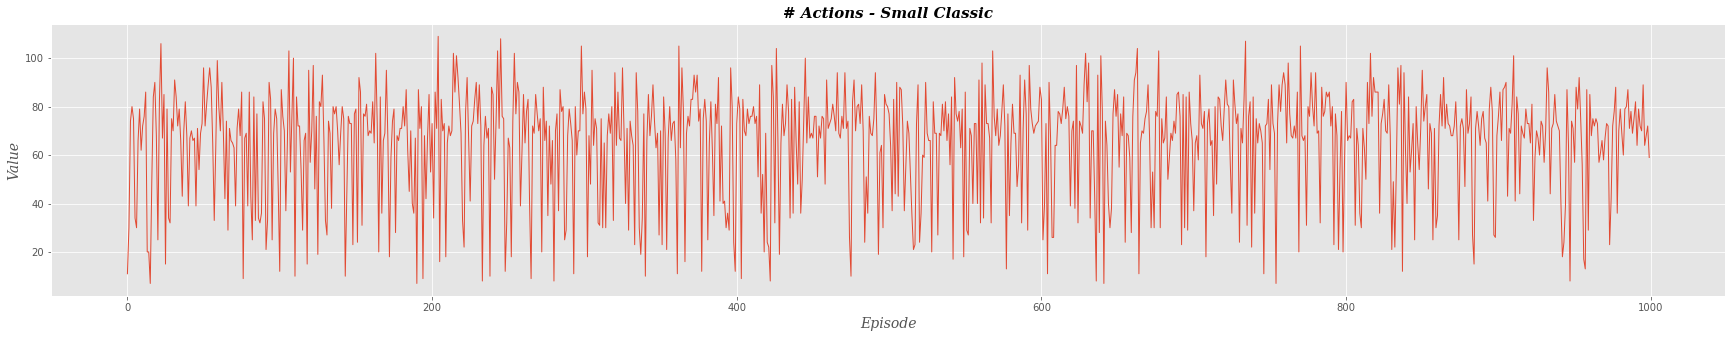

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(small_data))], small_data.Actions, linewidth=1)
ax1.set_title('# Actions - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

As we see above, the actions does not have a tendency and more action more actions do not imply more points. The range is greater, from 5 to 125.

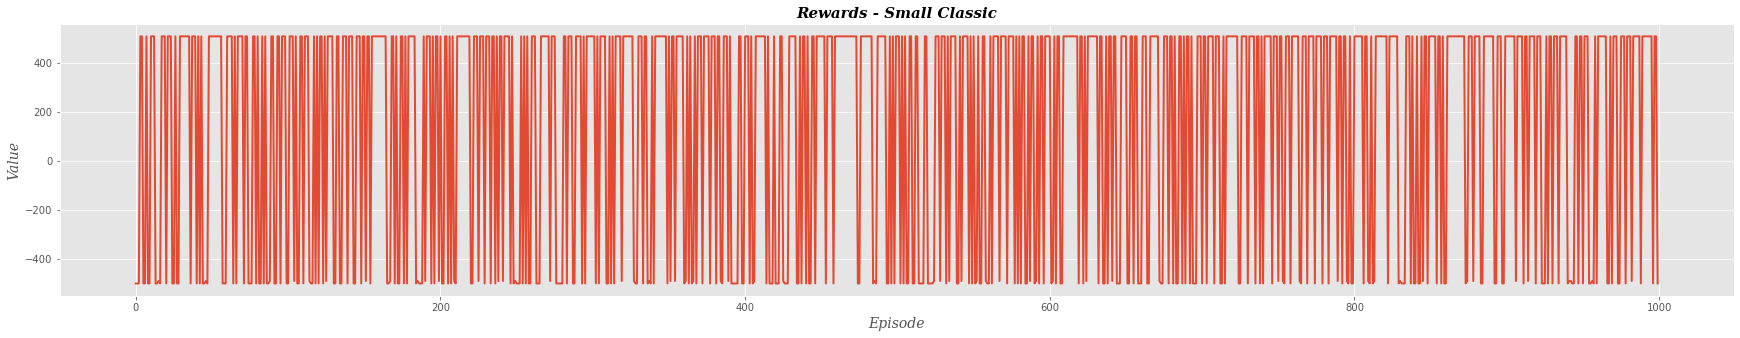

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(small_data))], small_data.Rewards, linewidth=2)
ax1.set_title('Rewards - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

The above plot shows 1000 episodes and their respective reward values. This graph does not clarify if there is a tendency of rewards through the episodes. So, we decided to plot the following graph:

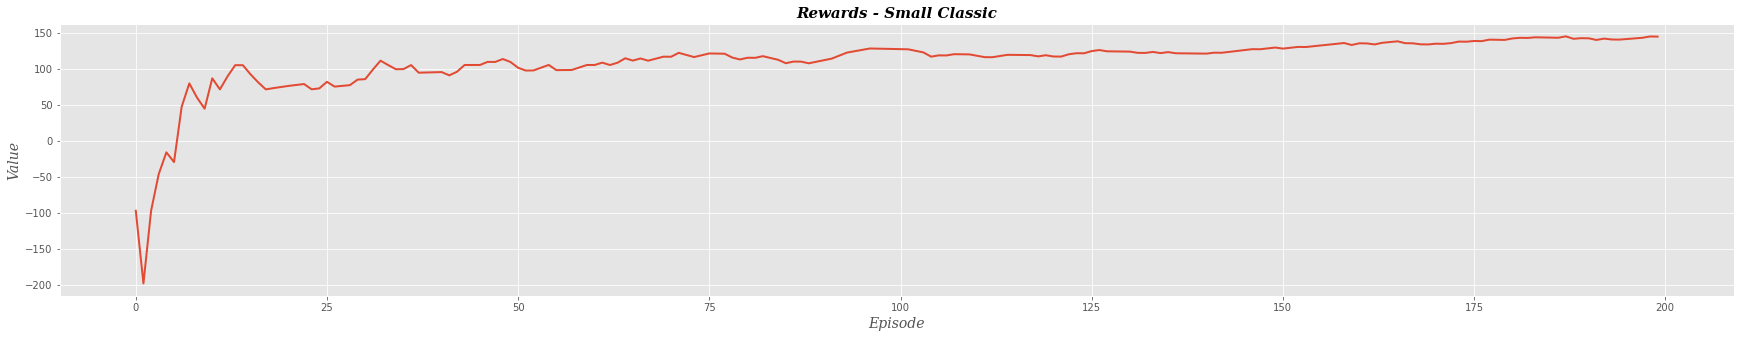

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(small_rewards))], small_rewards.rewards, linewidth=2)
ax1.set_title('Rewards - Small Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

The above plot shows the same episodes and their respective reward values but using a window of 5 training episodes. They y-axis shows the average of rewards for that episodes. We can see that the algorithm found an optimal solution, in this case, a local solution, once the algorithm does not use the pills to eat the ghosts. We do not see a higher difference after the window 50.

## Medium Classic World

In [ ]:
!python pacman.py -p RLAgent -x 1000 -n 1010 -l mediumClassic -q

Beginning 1000 episodes of Training
Training Process is Done
------------------------
	1000 training episodes 
	Average Rewards over all training: 223.86
Pacman emerges victorious! Score: 1514
Pacman died! Score: 17
Pacman emerges victorious! Score: 1335
Pacman emerges victorious! Score: 1337
Pacman emerges victorious! Score: 1335
Pacman emerges victorious! Score: 1330
Pacman emerges victorious! Score: 1342
Pacman emerges victorious! Score: 1332
Pacman emerges victorious! Score: 1338
Pacman emerges victorious! Score: 1342
Average Score: 1222.2
Scores:        1514.0, 17.0, 1335.0, 1337.0, 1335.0, 1330.0, 1342.0, 1332.0, 1338.0, 1342.0
Win Rate:      9/10 (0.90)
Record:        Win, Loss, Win, Win, Win, Win, Win, Win, Win, Win


As we can see in the above results, the model get 90% in the test cases on medium classic world, with 1000 training episodes. The average score in the tests episodes is 1222 points.

In [ ]:
medium_data = pd.read_excel('data_pacman.xlsx')
medium_rewards = pd.read_excel('rewards_pacman.xlsx')

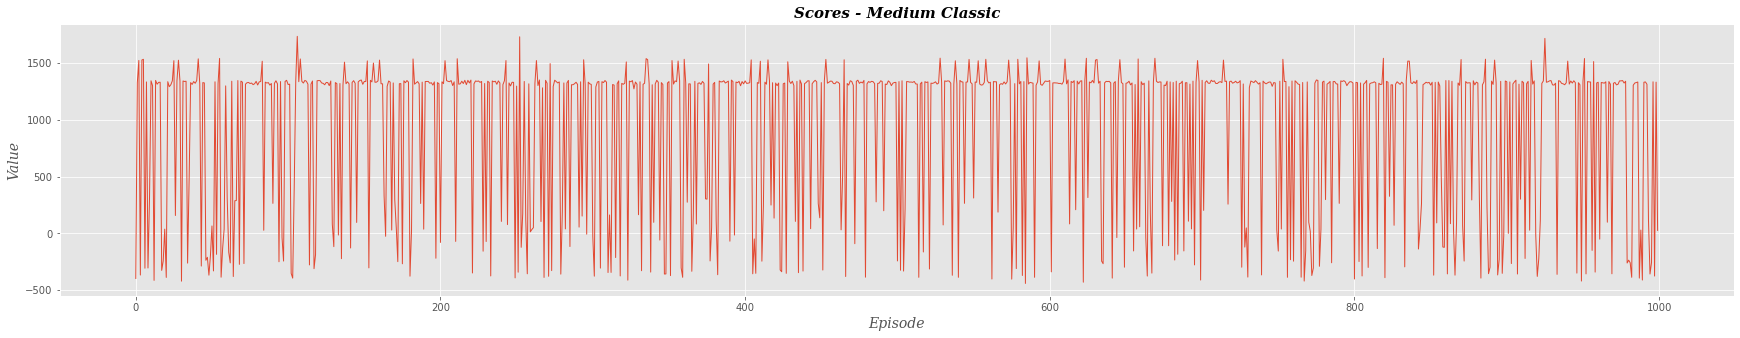

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(medium_data))], medium_data.Scores, linewidth=1)
ax1.set_title('Scores - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

The training scores, as we see in the small classic world, does not imply growth over the episodes, but changes abruptaly between them. The average score in the training process was 223.86.

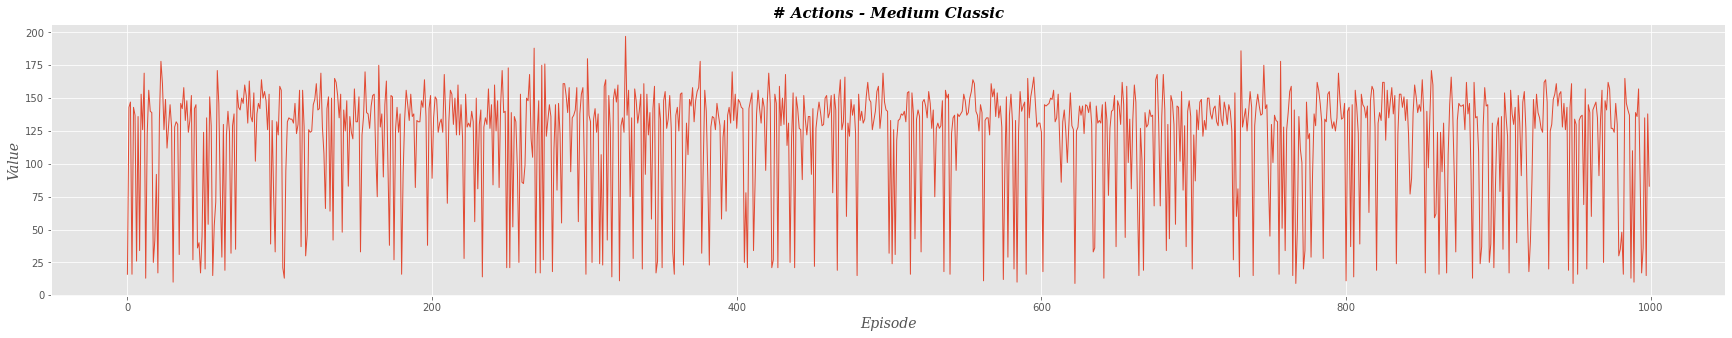

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(medium_data))], medium_data.Actions, linewidth=1)
ax1.set_title('# Actions - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

As we see above, the actions does not have a tendency and more actions do not imply more points.

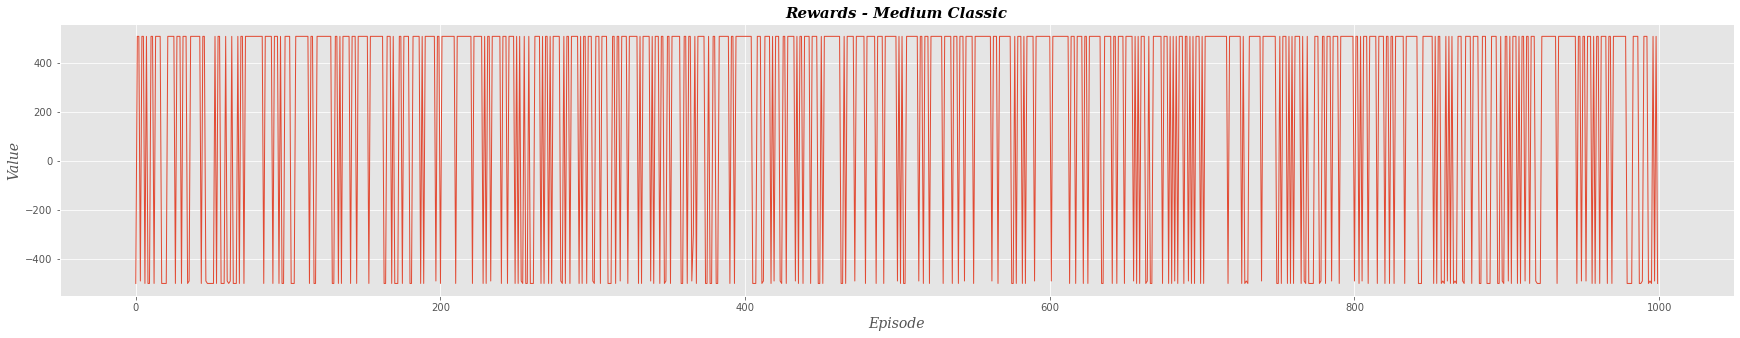

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(medium_data))], medium_data.Rewards, linewidth=1)
ax1.set_title('Rewards - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

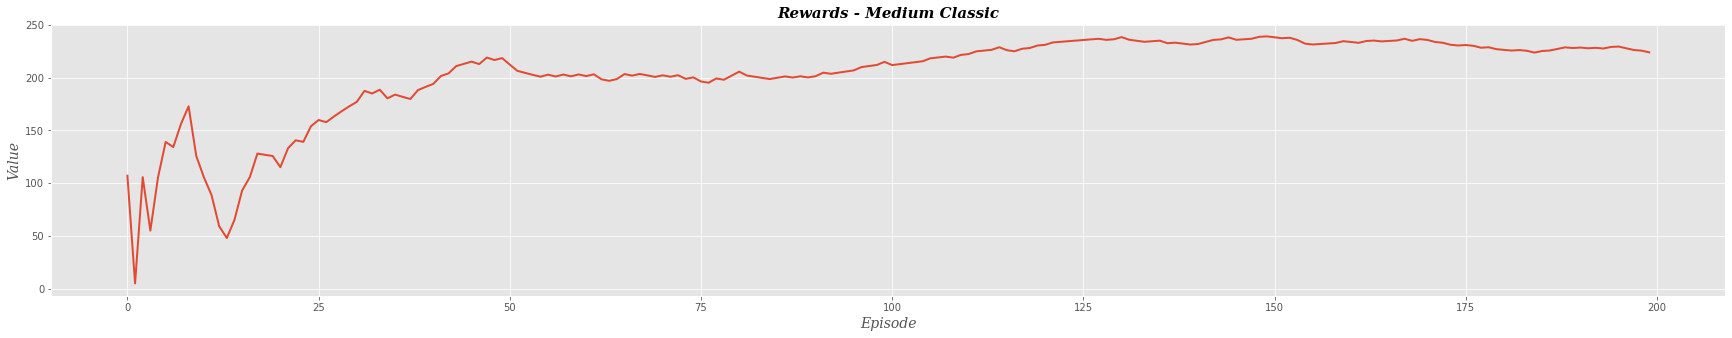

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(medium_rewards))], medium_rewards.rewards, linewidth=2)
ax1.set_title('Rewards - Medium Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

When we use a window of 5 training episodes calculating the average of rewards for that episodes, we see that the algorithm is in an optimal solution, in this case, a local solution because the algorithm do not use the pills to eat the ghosts. We do not see a higher difference after the window 125.

## Original Classic World

In [ ]:
!python pacman.py -p RLAgent -x 1000 -n 1010 -l originalClassic -q

Beginning 1000 episodes of Training
Training Process is Done
------------------------
	1000 training episodes 
	Average Rewards over all training: -77.25
Pacman emerges victorious! Score: 2419
Pacman emerges victorious! Score: 2453
Pacman died! Score: 1367
Pacman emerges victorious! Score: 2430
Pacman died! Score: 1154
Pacman emerges victorious! Score: 2427
Pacman died! Score: 530
Pacman died! Score: 402
Pacman emerges victorious! Score: 2459
Pacman emerges victorious! Score: 2430
Average Score: 1807.1
Scores:        2419.0, 2453.0, 1367.0, 2430.0, 1154.0, 2427.0, 530.0, 402.0, 2459.0, 2430.0
Win Rate:      6/10 (0.60)
Record:        Win, Win, Loss, Win, Loss, Win, Loss, Loss, Win, Win


As we see in the above results, the model gets 60% in the test cases on original classic world, with 1000 training episodes. The average score in the test episodes is 1807.1 points.

In [ ]:
original_data = pd.read_excel('data_pacman.xlsx')
original_rewards = pd.read_excel('rewards_pacman.xlsx')

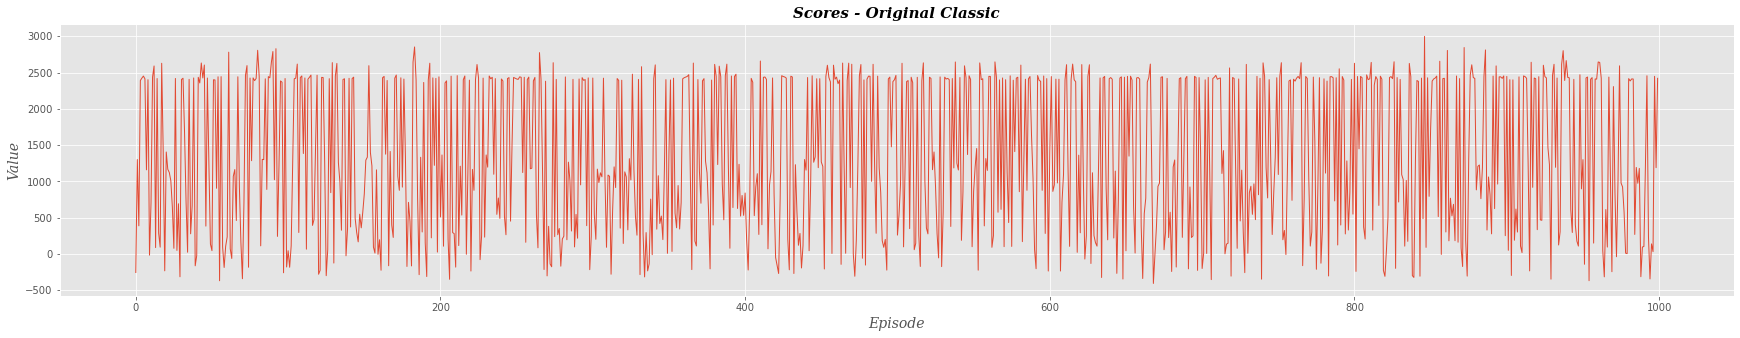

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(original_data))], original_data.Scores, linewidth=1)
ax1.set_title('Scores - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

The training scores, as we see in the others worlds, does not imply growth over the episodes, but changes abruptaly between then. The average score in the training process was -77.25. The score was low and can indicate that the model needs more episodes to get a better result or a new state representation.

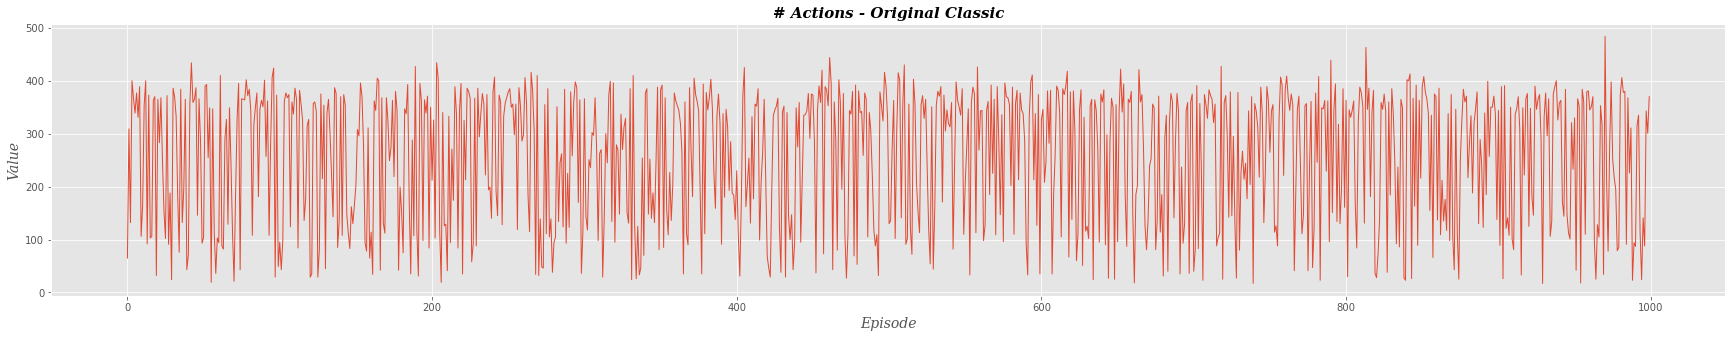

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(original_data))], original_data.Actions, linewidth=1)
ax1.set_title('# Actions - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

As we see above, the actions does not have a tendency and more actions do not imply more points.

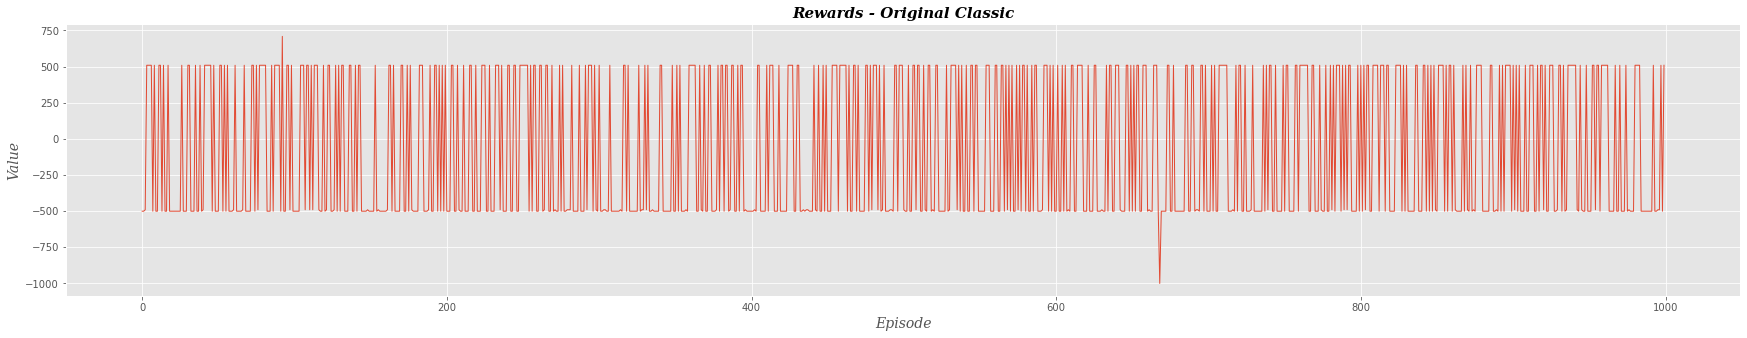

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(original_data))], original_data.Rewards, linewidth=1)
ax1.set_title('Rewards - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

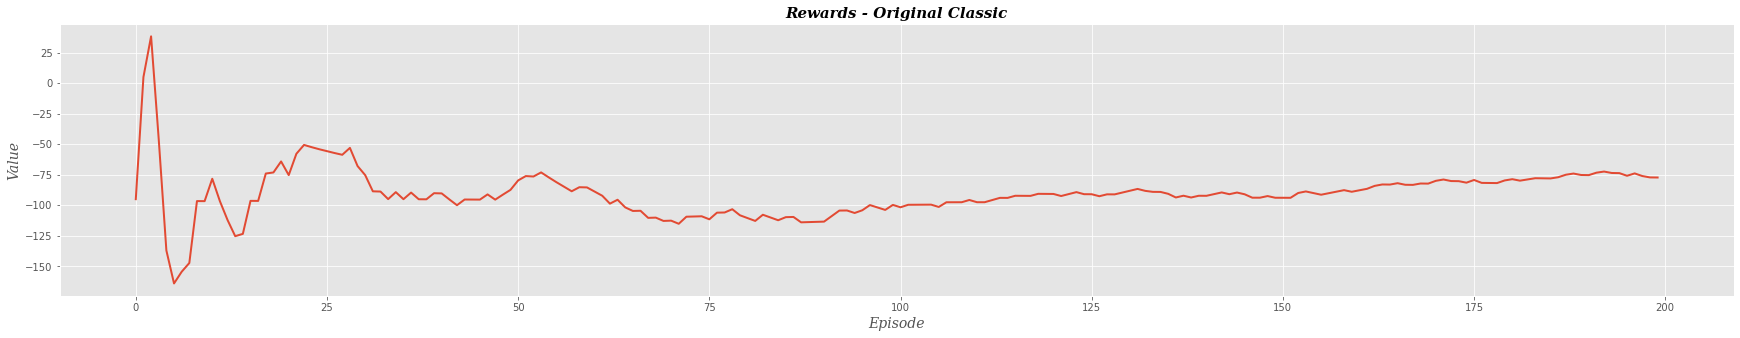

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot([i for i in range(len(original_rewards))], original_rewards.rewards, linewidth=2)
ax1.set_title('Rewards - Original Classic', fontdict=title_font)
ax1.set_ylabel('Value', fontdict=axis_font)
ax1.set_xlabel('Episode', fontdict=axis_font)
plt.show()

In this case, we see that the algorithm do not performe as we expected. One of the hypoteses can be the quantity of ghosts (4 in this layout and 2 in the others). A higher number of episodes or a new state modelling can be helpful to this layout.

# Our Analysis - Wrapping Up

### General

#### 1) Normalization
**Do we apply normalization in these datasets?**

No, we do not find interesting to apply normalization in Evolutionary Model (EM) or Reinforcement Learning (RF) algorithms. To the best of our knowledge, it is not very usual to apply mean 0 and standard deviation 1 in datasets that are used as input of RL algorithms.

### Part I - Evolutionary Model

#### 1) Model

**What was the chosen evolutionary model? Why?**

We adopted the Genetic Algorithm. We opted from the Genetic Algorithm instead of Genetic Programming because, to the best of our knowledge, it is simpler to implement.

#### 2) Parameters

**What are the parameters and what are their variations?**

We choose to not vary the majority of the parameters in the three layouts. 

The first parameter is the representation of a gene, which is composed by a list of 5 floats with range [0,100].

The second parameter worth mentioning is the chromossome, a group of genes (1000 genes in a single chromossome).

The third parameter is the fitness. We used the score achieved in the game and not the number of win/die.

The forth parameter is the population with size of 15 individuals.

The fifth parameter is related to the stop criteria, which is 50 generations for each layout and the winning or dying of pacman.

The sith parameter is the mutation rate of 15%.

Many of these parameters are used to initiate our genetic algorithm:



```
def __init__(self, popSize, mutationRate, crossoverRate, tournmentSize, numTrials, generations, world):
```



#### 3) Selection

**What did we use as selection technique?**

We used a tournment with 4 individuals.

#### 4) Crossover

**What do we have to say about the crossover?**

We adopted the double point with 100 genes change. The rate we adopted is the value of 70%. This rate indicates that in the next generation, we will only consider 70% of the population from the previous generation.

#### 5) Mutation

**What do we have to say about the mutation?**

We used the swap technique. The rate we adopted is the value of 15%.

#### 6) Replacement

**What do we have to say about the replacement method?**

We adopted a steady state, choosing the 5 best individuais of iteration (i - 1) and excluding the 5 worst of the current and intermediate population. 

#### 7) Layouts

**Did we see any difference running the RL experiments in each of the 3 layouts?**

Independent of the layout, we chose to run using the same parameters: population size, mutation and crossover rates, tournament size, trial and generation numbers.

#### 8) Improvements

**What do we think that should be improved in our algorithm?**

We found valid to add this section to analyse what could be improved in a sincere reflection about our algorithm and methods. In the genetic algorithm, we could have gotten better results if we had testes with more individuals and generations (because of time and processing resources we cannot test with many parameters combinations). Our algorithm could perform better or worse if we tried to explore novel forms to representate the states. Finally, the use of Genetic Programming could bring better results, based on its tree architecture.

### Part II - Reinforcement Learning

#### 1) MDP Formulation
**What were the parameters and values of our chosen MDP formulation?** 

The states are based on the following features:
* Number of ghosts 1 step closer (north, south, west, east);
* Ghosts 2 steps closer;
* Food available 1 step closer;
* Food available 2 step closer; 

The terminal state is end of the game (if Pacman wins or if a ghost captures him).

The actions are: go north, go east, go south, go west or stop.

The reward function is the episode score.


#### 2) Discretization Model

**What was the adopted discretization model?** 

The number of discrete actions in Pacman's game is not high. As mentioned earlier, the 5 possible actions makes the problem "easier" to address when compared to continuous state spaces and actions. 

Firstly, we were worried about the total number of possible states in a given play and how it could increase very fast (as long as the amount of storage needed). This situation could lead us to switch the states' storage and action to a neural network, for example. However, this was not the case.

With that in mind, we opted to adopt the following discretization model: 2 features (number of ghosts and available food, as described above in MDP Formulation section), 2 different measures for each (distance of 1 and 2 squares away from pacman) with 5 possible actions. 

#### 3) Algorithm Choice

**What was the chosen algorithm of RL paradigm?**

We chose Approximate Q-Learning given its off-police and model-free learning. The Approximate Q-Learning is also a good choice for discrete actions, which is the case for Pacman movements. We also choose to use Approximate Q-Learning based on the assumption that it (the algorithm) can calculate by itself the weights of the features, different from traditional Q-Learning.

#### 4) Stop Criteria

**What is the adopted stop criteria?**

We used as stop criteria the number of training episodes (10).

#### 5) Parameters

**What are the other parameters used?**

Alpha: Initially set as 1, this parameter is the learning rate.

Gama: Initially set as 0.8, this parameter is the discount value.

Epsilon: Initially set to 0.05, this parameter that sets how often the algorithm takes random movements.

**How each of the these parameters impact the results?**

The epsilon directly impacts the rewards gained by the pacman agent, or, in other words, the higher the value, the most random the agent walks and not find a good reward. We see the gamma as a "faucet" parameter: the more we tight it (increase the value), more penalized the pacman gets. And the epsilon we see as a random factor that can, sometimes, take pacman out of eternal loops and make it a little less rational (more "emotional", maybe).

#### 6) Layouts

**Did we see any difference running the RL experiments in each of the 3 layouts?**

The first difference worth mentioning is the running time. We observed that the bigger the layout, the slower is the run (considering that all other parameters are equal). To the best of our knowledge, we can also say in bigger puzzles, Pacman tends to dies more (~10% in smallClassic, ~10% in mediumClassic and ~40% in originalClassic), however, Pacman collects more points, once that the layout is bigger and has more "food" to be eaten.


#### 7) Convergence

**Did the algorithm run without problems? Or did it get stuck?**

Initially, our solution was not performing well, once that we were "poorly" representing our states. The algorithm could not learn with these states' representations, which directly affected pacman (e.g Pacman going up and down in loop, until some ghosts eat it). It was easier for Pacman to be in loop, not receiving points, instead of being caught and losing a lot of points.

We fixed that and, in our tests with 10 training episodes, we had no issues with pacman getting stuck, not moving or in a "deadlock" situation.

We also detected a little "instability" in the winning/losing graph of each layout (e.g for smallClassic, we could not see 9 wins in a row, for example). However, in our point of view, this does not diminish the results achieved by our algorithm using RL.

#### 8) Improvements

**What do we think that should be improved in our algorithm?**

Even though it achieved good results (better than the genetic algorithm), we found interesting to reflect on what we could have tested more and improved. Our first thought relates to the score improvement: to the best of our knowledge, if we use the pills in the state modelling, we could reach better results. Our second thought was related to the test of new parameters combination for each world.


# Responsabilities
**André Gomes Regino (RA 230252):** was responsible for the Wrapping Up Section and the explanation among the sections

**Hismael (RA 265684):** was responsible for the genetic algorithm and reinforcement learning